In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers


In [21]:
train_ds_path = "/kaggle/input/candle-image-data/Train"
test_ds_path = "/kaggle/input/candle-image-data/Test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)


Found 1433 images belonging to 2 classes.


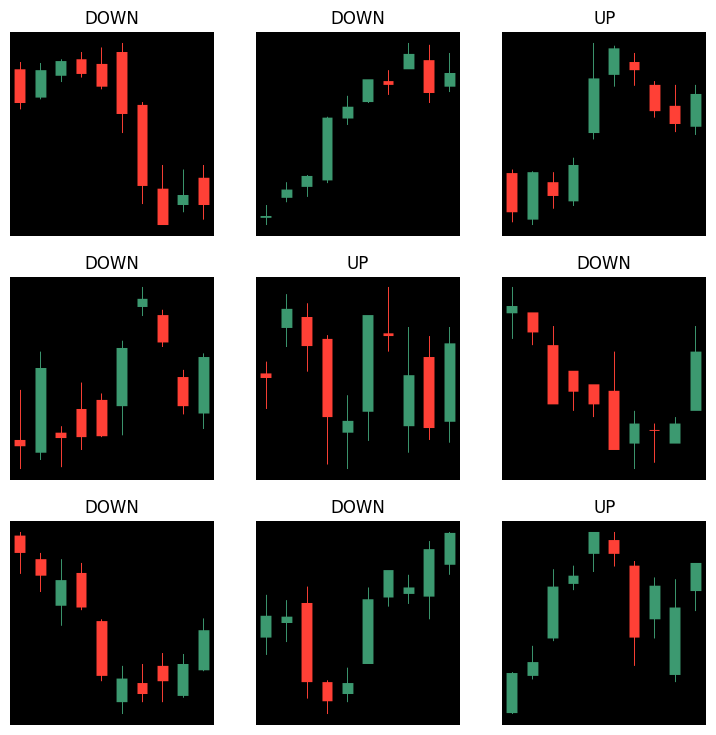

In [22]:
raw_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

images, labels = next(raw_gen)

plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("UP" if labels[i] == 1 else "DOWN")
    plt.axis("off")
plt.show()


Found 1433 images belonging to 2 classes.


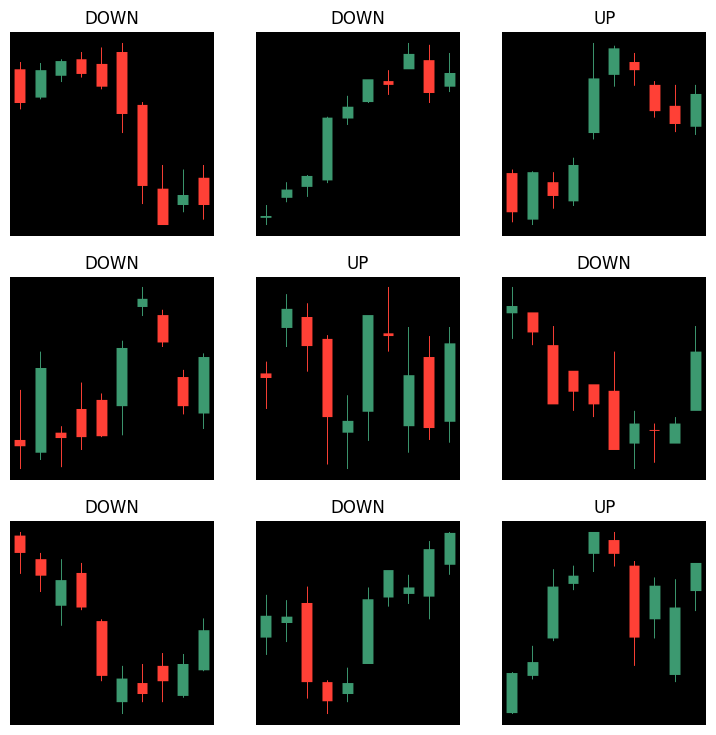

In [23]:
raw_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

images, labels = next(raw_gen)

plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("UP" if labels[i] == 1 else "DOWN")
    plt.axis("off")
plt.show()


## Data Augmentation Strategy

Augmentation is applied to improve generalization while preserving semantic meaning.

Applied:
- Small rotations
- Horizontal shifts
- Vertical shifts
- Zoom
- Brightness variation

Excluded:
- Vertical flip (would invert price-time semantics and destroy trend information)


Found 1433 images belonging to 2 classes.


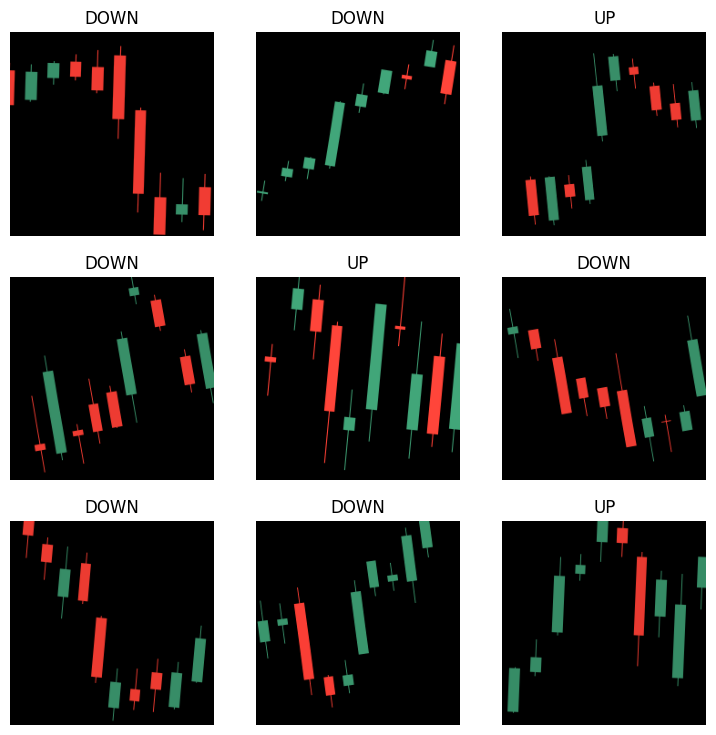

In [24]:
augmenter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=False
)

aug_gen = augmenter.flow_from_directory(
    train_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

aug_images, aug_labels = next(aug_gen)

plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_images[i])
    plt.title("UP" if aug_labels[i] == 1 else "DOWN")
    plt.axis("off")
plt.show()


In [25]:
train_gen = augmenter.flow_from_directory(
    train_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 1433 images belonging to 2 classes.
Found 351 images belonging to 2 classes.


## CNN Model Architecture

Design principles:
- Progressive feature extraction via convolution blocks
- MaxPooling for spatial downsampling
- Dropout for regularization
- Sigmoid output for binary classification


In [26]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])


In [27]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
EPOCHS = 15

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5424 - loss: 0.6888 - val_accuracy: 0.5413 - val_loss: 0.6915
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5723 - loss: 0.6877 - val_accuracy: 0.5527 - val_loss: 0.6906
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5848 - loss: 0.6776 - val_accuracy: 0.5499 - val_loss: 0.6925
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5776 - loss: 0.6738 - val_accuracy: 0.5613 - val_loss: 0.6973
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5837 - loss: 0.6755 - val_accuracy: 0.5328 - val_loss: 0.7005
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6106 - loss: 0.6617 - val_accuracy: 0.5413 - val_loss: 0.7085
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5950 - loss: 0.6567 - val_accuracy: 0.5271 - val_loss: 0.7055
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5725 - loss: 0.6780 - val_accuracy: 0.5356 - val_loss

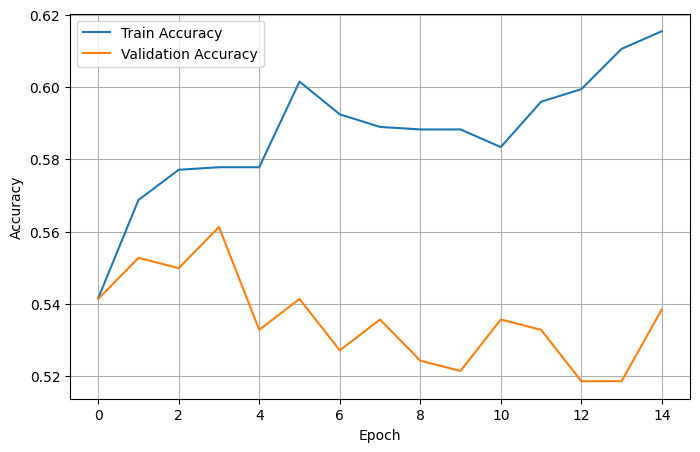

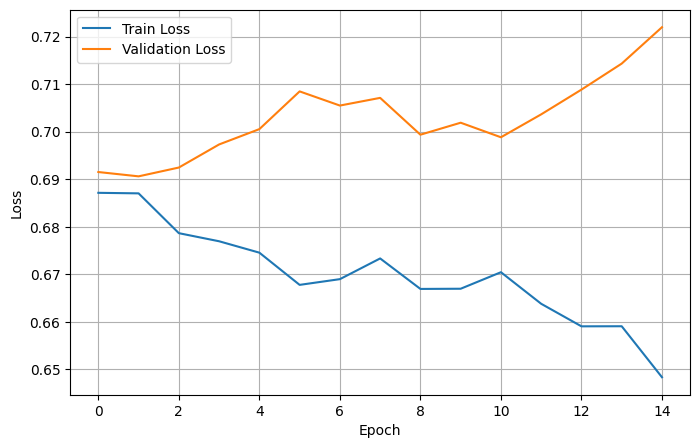

In [29]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model Summary

The proposed model is a convolutional neural network designed to learn hierarchical visual patterns from candlestick chart images for binary market direction prediction.  
Convolutional layers progressively extract local features such as candle shapes, wicks, and short-term trend structures, while max-pooling layers reduce spatial dimensionality and enforce translational invariance.  
ReLU activations introduce non-linearity, enabling the model to capture complex market visual patterns beyond linear separability.  
Dropout regularization is applied in the fully connected layer to mitigate overfitting, which is critical given the limited size of financial image datasets.  
The final sigmoid-activated output layer models the probability of an upward market movement, making the architecture suitable for binary classification.
